In [1]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import time
import os

# Sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Tensorflow/Keras
import tensorflow as tf

# Load Data

In [5]:
# Load data
train_df = pd.read_csv("../processed_data/train_df.csv")
train_df['DATE_TIME']= pd.to_datetime(train_df['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

# These were exported to train_df.csv
#train_df["HOUR"] = train_df['DATE_TIME'].dt.hour
#train_df.dropna(inplace=True)
#train_df.reset_index(drop=True, inplace=True)

test_df = pd.read_csv("../processed_data/test_df.csv")
test_df['DATE_TIME']= pd.to_datetime(test_df['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

# These were exported to test_df.csv
#test_df["HOUR"] = test_df['DATE_TIME'].dt.hour
#test_df.dropna(inplace=True)
#test_df.reset_index(drop=True, inplace=True)


mae_results = {}
rmse_results = {}

train_df = train_df.dropna()
test_df = test_df.dropna()

In [6]:
len(train_df) + len(test_df)

136476

#### Function that scaled DC_POWER of plant 1 down by 10. New values were exported to train_df.csv and test_df.csv.

In [3]:
# def scale_down_plant_1(df):
#     for i in df.index:
#         if(df.iloc[i].PLANT_ID == 4135001):
#             df.loc[i,'DC_POWER'] = df.iloc[i].DC_POWER/10
            
# scale_down_plant_1(train_df)
# scale_down_plant_1(test_df)

# train_df.to_csv("../processed_data/train_df.csv", index=False)
# test_df.to_csv("../processed_data/test_df.csv", index=False)

In [4]:
def calculate_metrics(label, true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae_results[label] = mae
    rmse_results[label] = rmse
    print(label + " MAE: " + str(mae) + " kW.")
    print(label + " RMSE: " + str(rmse) + " kW.")
    
def plot_true_vs_pred(label, true, pred):
    x_ax = range(len(true))
    plt.plot(x_ax, true, label="original")
    plt.plot(x_ax, pred, label="predicted")
    plt.title("Test and Predicted Data " + label)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

# Baseline Predictor

#### Baseline predictor predicts the average train AC power for everything.

In [5]:
baseline_train_y = train_df.AC_POWER
baseline_test_y = test_df.AC_POWER

baseline = baseline_train_y.mean()
calculate_metrics("Baseline", baseline_test_y, [baseline]*len(baseline_test_y))

Baseline MAE: 293.85475863244017 kW.
Baseline RMSE: 336.7762729048805 kW.


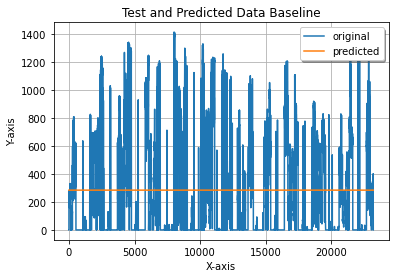

In [6]:
plot_true_vs_pred("Baseline", baseline_test_y, [baseline]*len(baseline_test_y))

# Linear Regression 1

#### Linear regression predictor. Grid search cross validation.

#### Set features and targets

In [7]:
# 'TIME' performs better than 'HOUR' in this case
lr_features = ["PLANT_ID", "SOURCE_KEY", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "TIME"]

# Train data
lr_train_x = train_df[lr_features]
lr_train_y = train_df.AC_POWER

lr_train_x.PLANT_ID = lr_train_x.PLANT_ID.astype("category")
lr_train_x = pd.get_dummies(lr_train_x)

# Standardize data
stdn = preprocessing.StandardScaler()
stdn.fit(lr_train_x)
lr_train_x = stdn.transform(lr_train_x)


# Test data
lr_test_x = test_df[lr_features]
lr_test_y = test_df.AC_POWER

lr_test_x.PLANT_ID = lr_test_x.PLANT_ID.astype("category")
lr_test_x = pd.get_dummies(lr_test_x)

# Standardize data
lr_test_x = stdn.transform(lr_test_x)

/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [8]:
lr1_parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}

lr_1 = GridSearchCV(LinearRegression(), lr1_parameters, scoring='neg_mean_squared_error', n_jobs=-1)
lr_1.fit(lr_train_x, lr_train_y)

print("Linear regression parameters: ", lr_1.best_params_)

Linear regression parameters:  {'copy_X': True, 'fit_intercept': True}


In [9]:
lr_1_preds = lr_1.predict(lr_test_x)
calculate_metrics("Linear Regression 1", lr_test_y, lr_1_preds)

Linear Regression 1 MAE: 82.44209954710061 kW.
Linear Regression 1 RMSE: 145.0092917172215 kW.


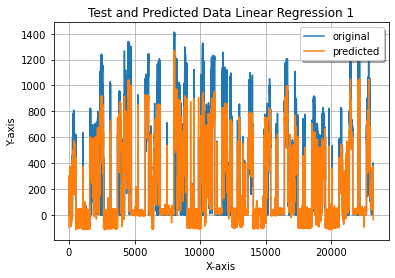

In [10]:
plot_true_vs_pred("Linear Regression 1", lr_test_y, lr_1_preds)

# Linear Regression 2 (Ridge)

#### Linear regression with ridge regularization. Grid search cross validation.

In [11]:
lr_reg_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}

lr_2 = GridSearchCV(Ridge(), lr_reg_parameters, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1)
lr_2.fit(lr_train_x, lr_train_y)

print("Linear regression 2 (Ridge) parameters: ", lr_2.best_params_)

Linear regression 2 (Ridge) parameters:  {'alpha': 100}


In [12]:
lr_2_preds = lr_2.predict(lr_test_x)
calculate_metrics("Linear Regression Ridge", lr_test_y, lr_2_preds)

Linear Regression Ridge MAE: 82.40352519076966 kW.
Linear Regression Ridge RMSE: 145.0194105534608 kW.


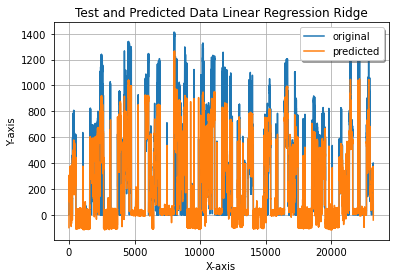

In [13]:
plot_true_vs_pred("Linear Regression Ridge", lr_test_y, lr_2_preds)

# Linear Regression 3 (Lasso)

#### Linear regression with lasso regularization. Grid search cross validation.

In [15]:
lr_3 = GridSearchCV(Lasso(), lr_reg_parameters, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1)
lr_3.fit(lr_train_x, lr_train_y)

print("Linear regression 3 (Lasso) parameters: ", lr_3.best_params_)

KeyboardInterrupt: 

In [16]:
lr_3_preds = lr_3.predict(lr_test_x)
calculate_metrics("Linear Regression Lasso", lr_test_y, lr_3_preds)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [17]:
plot_true_vs_pred("Linear Regression Lasso", lr_test_y, lr_3_preds)

NameError: name 'lr_3_preds' is not defined

# Decision Tree 1

#### Decision tree predictor. Grid search cross validation on decision tree max depths 1-50. No need to standardize data for trees.

#### Set features and targets

In [18]:
train_df.columns

Index(['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER',
       'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE',
       'MODULE_TEMPERATURE', 'IRRADIATION', 'WEATHER_SOURCE', 'DATE', 'TIME',
       'is_daytime', 'yesterday_max_daily_yield'],
      dtype='object')

In [49]:
# I found using 'HOUR' rather than 'TIME' results in higher accuracy in this case.
tree_1_features = ["PLANT_ID", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "TIME", "is_daytime", "yesterday_max_daily_yield"]
# DC_Power as a feature brings the lowest MAE possible thus far

# Train data
tree_1_train_x = train_df[tree_1_features]
tree_1_train_y = train_df.AC_POWER

# One-hot-encode categories
tree_1_train_x.PLANT_ID = tree_1_train_x.PLANT_ID.astype("category")
tree_1_train_x.TIME = tree_1_train_x.TIME.astype("category")
tree_1_train_x.is_daytime = tree_1_train_x.is_daytime.astype("category")
tree_1_train_x = pd.get_dummies(tree_1_train_x)


# Test data
tree_1_test_x = test_df[tree_1_features].dropna()
tree_1_test_y = test_df.AC_POWER

# One-hot-encode categories
tree_1_test_x.PLANT_ID = tree_1_test_x.PLANT_ID.astype("category")
tree_1_test_x.TIME = tree_1_test_x.TIME.astype("category")
tree_1_test_x.is_daytime = tree_1_test_x.is_daytime.astype("category")


tree_1_test_x = pd.get_dummies(tree_1_test_x)

/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [50]:
dt_1_parameters = {'max_depth': range(1,50)}
dt_1 = GridSearchCV(DecisionTreeRegressor(random_state=100), 
                    dt_1_parameters, 
                    return_train_score=True,
                    verbose=3,
                    scoring='neg_mean_squared_error', 
                    n_jobs=-1)

dt_1.fit(tree_1_train_x, tree_1_train_y)
print("Optimal decision best parameters: ", dt_1.best_params_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Optimal decision best parameters:  {'max_depth': 6}


In [51]:
dt_1_preds = dt_1.predict(tree_1_test_x)
calculate_metrics("Decision Tree 1", tree_1_test_y, dt_1_preds)
# With DC_POWER MAE is 0.219 and RMSE is 0.862
#W/o SOURCE KEY MAE is 31.12 and RMSE is 98.25

Decision Tree 1 MAE: 42.18797205893677 kW.
Decision Tree 1 RMSE: 122.15039308937466 kW.


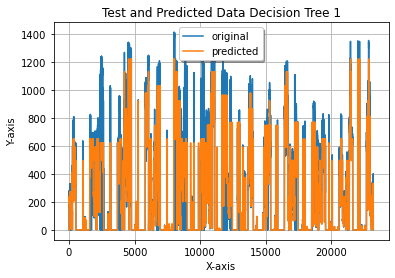

In [52]:
plot_true_vs_pred("Decision Tree 1", tree_1_test_y, dt_1_preds)

In [53]:
feature_importances = pd.Series(dt_1.best_estimator_.feature_importances_, 
                               index=tree_1_train_x.columns)
print("Feature importance:")
feature_importances.sort_values(ascending=False)[:25]

Feature importance:


IRRADIATION                  0.954200
PLANT_ID_4135001             0.027469
yesterday_max_daily_yield    0.014100
AMBIENT_TEMPERATURE          0.003448
MODULE_TEMPERATURE           0.000208
TIME_14:00:00                0.000195
TIME_07:45:00                0.000100
TIME_16:30:00                0.000091
TIME_08:00:00                0.000072
TIME_13:45:00                0.000039
TIME_07:30:00                0.000029
TIME_07:15:00                0.000029
TIME_07:00:00                0.000011
TIME_08:15:00                0.000009
TIME_17:00:00                0.000000
TIME_17:15:00                0.000000
TIME_16:15:00                0.000000
TIME_16:45:00                0.000000
TIME_15:30:00                0.000000
TIME_16:00:00                0.000000
TIME_15:45:00                0.000000
TIME_17:45:00                0.000000
TIME_15:15:00                0.000000
TIME_15:00:00                0.000000
TIME_14:45:00                0.000000
dtype: float64

In [24]:
dot_data = export_graphviz(dt_1.best_estimator_,
                          out_file=None,
                          feature_names=tree_1_train_x.columns,
                          proportion=True,
                          impurity=True,
                          filled=True,
                          rounded=True)
graph = graphviz.Source(dot_data)
graph.render('..models/decision_tree_1_viz')

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

<AxesSubplot:xlabel='depth'>

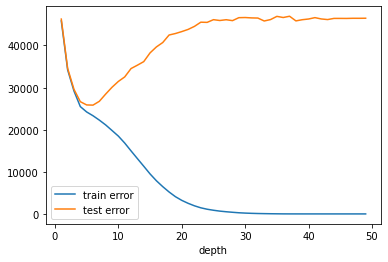

In [39]:
results = pd.DataFrame()
results['depth'] = dt_1_parameters['max_depth']
results['train error'] = 1 - dt_1.cv_results_['mean_train_score']
results['test error'] = 1 -  dt_1.cv_results_['mean_test_score']
ax1 = results.plot.line(x='depth', y='train error')
results.plot.line(x='depth', y='test error', ax=ax1)

# Random Forest

#### Radom forest predictor.

In [40]:
#rf_params = {'max_depth': np.arange(5, 50, 5), 'n_estimators':np.arange(5, 200, 5)}
#rf_params = {'max_depth': np.arange(5, 10, 5), 'n_estimators':np.arange(5, 10, 5)}
#rf_params = {'max_depth': np.arange(5, 50, 5), 'n_estimators':np.arange(5, 30, 5)}
rf_params = {'max_depth': np.arange(1, 14, 1), 'n_estimators':np.arange(1, 20, 1)}

rfCV = GridSearchCV(RandomForestRegressor(random_state=1), rf_params, 
                    return_train_score=True, 
                    scoring='neg_mean_squared_error', 
                    verbose=1, 
                    n_jobs=-1)

start = time.time()
rfCV.fit(tree_1_train_x, tree_1_train_y)
end = time.time()
print(str((end - start)/60) + " minutes to train random forest.")

print('Random Forest Regresor:')
print(' Optimal Parameters:', rfCV.best_params_)
print(' Optimal test R2:', rfCV.best_score_.round(3))

Fitting 5 folds for each of 247 candidates, totalling 1235 fits
4.275912849108378 minutes to train random forest.
Random Forest Regresor:
 Optimal Parameters: {'max_depth': 6, 'n_estimators': 16}
 Optimal test R2: -25294.189


In [41]:
rf_preds = rfCV.predict(tree_1_test_x)
calculate_metrics("Random Forest", tree_1_test_y, rf_preds)

Random Forest MAE: 42.34583716677215 kW.
Random Forest RMSE: 122.97332081583492 kW.


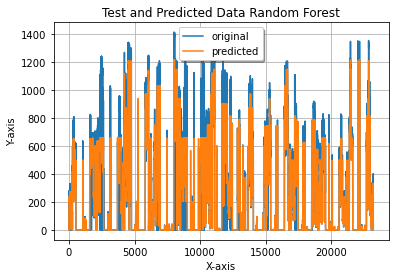

In [42]:
plot_true_vs_pred("Random Forest", tree_1_test_y, rf_preds)

In [43]:
feature_importances = pd.Series(rfCV.best_estimator_.feature_importances_, 
                               index=tree_1_train_x.columns)
print("Feature importance:")
feature_importances.sort_values(ascending=False)[:25]

Feature importance:


IRRADIATION                  9.530592e-01
PLANT_ID_4135001             1.901793e-02
yesterday_max_daily_yield    1.508955e-02
PLANT_ID_4136001             8.466360e-03
AMBIENT_TEMPERATURE          3.446435e-03
MODULE_TEMPERATURE           3.937184e-04
TIME_14:00:00                1.759476e-04
TIME_16:30:00                8.391582e-05
TIME_07:45:00                5.376620e-05
TIME_13:45:00                4.419075e-05
TIME_07:30:00                3.746063e-05
TIME_08:00:00                3.706074e-05
TIME_07:15:00                3.126398e-05
TIME_12:30:00                2.025627e-05
TIME_07:00:00                1.416794e-05
TIME_08:15:00                7.623591e-06
TIME_13:30:00                6.507741e-06
TIME_12:45:00                5.216136e-06
TIME_14:15:00                4.192051e-06
TIME_10:45:00                4.164320e-06
TIME_15:30:00                5.608330e-07
TIME_17:45:00                5.163073e-07
TIME_15:15:00                0.000000e+00
TIME_16:45:00                0.000

# Gradient Boosting Trees

#### Gradient boosting tree predictors.

In [44]:
#gb_params = {'max_depth': np.arange(5, 50, 5), 'n_estimators':np.arange(5, 200, 5)}
gb_params = {'max_depth': np.arange(1, 14, 2), 'n_estimators':np.arange(1, 14, 2)}
#gb_params = {'max_depth': np.arange(1, 12, 1), 'n_estimators':np.arange(1, 16, 1)}

gbtCV = GridSearchCV(GradientBoostingRegressor(learning_rate=0.56, random_state=1), gb_params, 
                     return_train_score=True, 
                     scoring='neg_mean_squared_error', 
                     verbose=1, 
                     n_jobs=-1)

start = time.time()
gbtCV.fit(tree_1_train_x, tree_1_train_y)
end = time.time()
print(str((end - start)/60) + " minutes to train gradient boosting trees.")

print('Random Forest Regresor:')
print(' Optimal Parameters:', gbtCV.best_params_)
print(' Optimal test R2:', gbtCV.best_score_.round(3))

Fitting 5 folds for each of 49 candidates, totalling 245 fits
1.02208571434021 minutes to train gradient boosting trees.
Random Forest Regresor:
 Optimal Parameters: {'max_depth': 3, 'n_estimators': 5}
 Optimal test R2: -25887.301


In [45]:
gbt_preds = gbtCV.predict(tree_1_test_x)
calculate_metrics("Gradient Boosting", tree_1_test_y, gbt_preds)

Gradient Boosting MAE: 49.49836754982252 kW.
Gradient Boosting RMSE: 123.28771947375535 kW.


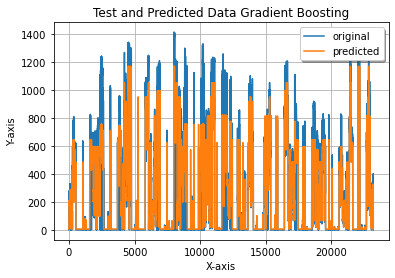

In [46]:
plot_true_vs_pred("Gradient Boosting", tree_1_test_y, gbt_preds)

In [47]:
feature_importances = pd.Series(rfCV.best_estimator_.feature_importances_, 
                               index=tree_1_train_x.columns)
print("Feature importance:")
feature_importances.sort_values(ascending=False)[:25]

Feature importance:


IRRADIATION                  9.530592e-01
PLANT_ID_4135001             1.901793e-02
yesterday_max_daily_yield    1.508955e-02
PLANT_ID_4136001             8.466360e-03
AMBIENT_TEMPERATURE          3.446435e-03
MODULE_TEMPERATURE           3.937184e-04
TIME_14:00:00                1.759476e-04
TIME_16:30:00                8.391582e-05
TIME_07:45:00                5.376620e-05
TIME_13:45:00                4.419075e-05
TIME_07:30:00                3.746063e-05
TIME_08:00:00                3.706074e-05
TIME_07:15:00                3.126398e-05
TIME_12:30:00                2.025627e-05
TIME_07:00:00                1.416794e-05
TIME_08:15:00                7.623591e-06
TIME_13:30:00                6.507741e-06
TIME_12:45:00                5.216136e-06
TIME_14:15:00                4.192051e-06
TIME_10:45:00                4.164320e-06
TIME_15:30:00                5.608330e-07
TIME_17:45:00                5.163073e-07
TIME_15:15:00                0.000000e+00
TIME_16:45:00                0.000

# Feed Forward Neural Network 1

#### FF neural network predictor.

In [48]:
def plot_history(history):
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(history['loss'] + 1)))
    plt.plot(history['loss'], label="training", marker='o')
    plt.plot(history['val_loss'], label="validation", marker='o')
    plt.legend()
    plt.show()
    
def build_model(lr=0.0001):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()

#     model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='relu'))

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

Epoch 1/20
1183/1183 [==============================] - 2s 1ms/step - loss: 45619.0273 - root_mean_squared_error: 213.5861 - val_loss: 19393.6426 - val_root_mean_squared_error: 139.2611
Epoch 2/20
1183/1183 [==============================] - 1s 1ms/step - loss: 26485.9883 - root_mean_squared_error: 162.7452 - val_loss: 16438.2207 - val_root_mean_squared_error: 128.2116
Epoch 3/20
1183/1183 [==============================] - 1s 1ms/step - loss: 24530.7402 - root_mean_squared_error: 156.6229 - val_loss: 15382.1719 - val_root_mean_squared_error: 124.0249
Epoch 4/20
1183/1183 [==============================] - 2s 1ms/step - loss: 23710.3359 - root_mean_squared_error: 153.9816 - val_loss: 14564.2324 - val_root_mean_squared_error: 120.6824
Epoch 5/20
1183/1183 [==============================] - 2s 1ms/step - loss: 23279.7715 - root_mean_squared_error: 152.5771 - val_loss: 14274.1279 - val_root_mean_squared_error: 119.4744
Epoch 6/20
1183/1183 [==============================] - 2s 1ms/step - 

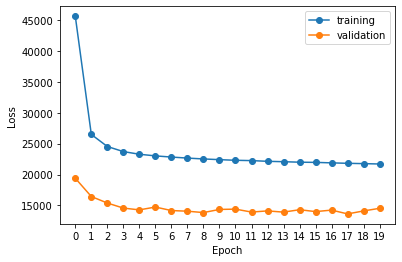

In [103]:
model_path = "./NeuralNets/Jacob/FFNN1/"

ffnn1 = build_model(lr=0.001)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path + "{epoch:02d}-{val_loss:.3f}", 
                                                monitor='val_loss', 
                                                save_best_only=True,
                                                save_weights_only=False, 
                                                mode='max', verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = ffnn1.fit(
  x = lr_train_x,  
  y = lr_train_y,         
  epochs=20,             
  batch_size=80,
  #callbacks=[checkpoint, earlystopping],
  validation_split=0.1, 
  verbose=1             
  )

history = pd.DataFrame(history.history)
plot_history(history)

In [104]:
# Load the best model
# files = os.listdir(model_path)
# paths = [os.path.join(model_path, basename) for basename in files if basename != "trainHistoryDict"]
# newestModelPath = max(paths, key=os.path.getctime)

# ffnn1 = tf.keras.models.load_model(newestModelPath)

# Evaluate
ffnn1_preds = ffnn1.predict(lr_test_x)
calculate_metrics("FFNN 1", lr_test_y, ffnn1_preds)

725/725 [==============================] - 0s 589us/step
FFNN 1 MAE: 47.985696094016745 kW.
FFNN 1 RMSE: 143.11726072352928 kW.


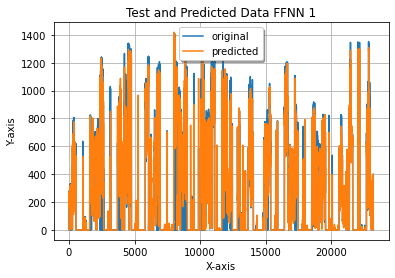

In [105]:
plot_true_vs_pred("FFNN 1", lr_test_y, ffnn1_preds)

# Results

In [106]:
model_results_df = pd.DataFrame([mae_results, rmse_results]).T
model_results_df.columns = ["MAE", "RMSE"]
model_results_df.sort_values(by='MAE', ascending=True)

,MAE,RMSE
Random Forest,32.636905,100.199352
Gradient Boosting,32.996776,96.563279
Decision Tree 1,33.326696,104.195125
FFNN 1,47.985696,143.117261
Linear Regression Ridge,82.403525,145.019411
Linear Regression Lasso,82.430905,145.036339
Linear Regression 1,82.442100,145.009292
Baseline,293.854759,336.776273
